In [1]:
#Data from https://housestockwatcher.com/

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
transaction_data_df = pd.read_csv('all_transactions.csv')

In [3]:
transaction_data_df['amount'] = transaction_data_df['amount'].str.replace("\n", "", regex = True)
transaction_data_df = transaction_data_df.drop(columns = 'ptr_link')
transaction_data_df['transaction_date'] = pd.to_datetime(transaction_data_df['transaction_date'], errors = 'coerce')
transaction_data_df.dropna(inplace = True)
transaction_data_df.head(10)

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,cap_gains_over_200_usd
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,False
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,False
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,False
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,False
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,False
5,2021,12/01/2021,2021-12-01,joint,AXP,American Express Company,purchase,"$1,001 - $15,000",Hon. Aston Donald McEachin,VA04,False
14,2021,11/02/2021,2021-10-13,joint,MO,Altria Group Inc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,False
15,2021,11/02/2021,2021-10-07,joint,DUKH,Duke Energy Corporation 5.125% Junior Subordin...,sale_full,"$50,001 - $100,000",Hon. Virginia Foxx,NC05,False
16,2021,11/02/2021,2021-10-08,joint,GSK,GlaxoSmithKline PLC,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,False
17,2021,11/02/2021,2021-10-07,joint,OLP,One Liberty Properties Inc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,False


In [4]:
transaction_data_df.loc[0,'amount']

'$1,001 - $15,000'

In [5]:
transaction_data_df['amount'].unique()

array(['$1,001 - $15,000', '$15,001 - $50,000', '$50,001 - $100,000',
       '$1,001 -', '$100,001 - $250,000', '$250,001 - $500,000',
       '$500,001 - $1,000,000', '$5,000,001 - $25,000,000',
       '$1,000,001 - $5,000,000', '$1,000,000 +', '$1,000 - $15,000',
       '$15,000 - $50,000', '$50,000,000 +'], dtype=object)

In [6]:
def strip_nonnumeric(word):
    result = ""
    for i in range(len(word)):
        if word[i].isnumeric():
            result += word[i]
    return result

estimates_dict = {}
estimates = []
A = []
B = []
for cat in transaction_data_df['amount'].unique():
    a = int(strip_nonnumeric(cat[:cat.find(" ")]))
    #print(f"a = {a},b = {b}")
    if a not in A:
        A.append(a)
        b = strip_nonnumeric(cat[cat.find(" "):])
        if b != "":
            B.append(int(b))
            estimates.append((a+int(b))/2)
        else:
            estimates.append(a)
        estimates_dict[cat] = estimates[-1]
    else:
        estimates_dict[cat] = estimates[A.index(a)]

In [7]:
sgn_dict = {}
for t in transaction_data_df['type'].unique():
    if 'purchase' in t:
        sgn_dict[t] = 1
    else:
        sgn_dict[t] = -1
        
transaction_data_df['sgn'] = transaction_data_df['type'].map(lambda x: sgn_dict[x])

In [8]:
#print(estimates_dict)
transaction_data_df['estimates'] = transaction_data_df['amount'].map(lambda x: estimates_dict[x]) * transaction_data_df['sgn']

In [9]:
temp = transaction_data_df.groupby(['ticker', 'transaction_date'])[['estimates']].sum()
temp.head()

estimates
ticker transaction_date           
--     2018-09-08           8000.5
       2018-09-09           8000.5
       2019-01-25        -150001.0
       2019-03-19        -175000.5
       2019-04-03        -375000.5

In [10]:
temp = temp.reset_index()
temp

,ticker,transaction_date,estimates
0,--,2018-09-08,8000.5
1,--,2018-09-09,8000.5
2,--,2019-01-25,-150001.0
3,--,2019-03-19,-175000.5
4,--,2019-04-03,-375000.5
...,...,...,...
6752,ZTS,2020-07-21,-8000.5
6753,ZTS,2020-08-07,-8000.5
6754,ZTS,2020-11-25,0.0
6755,ZTS,2021-08-09,8000.5


In [11]:
temp = temp.pivot(index = 'transaction_date', columns = 'ticker', values = 'estimates')
temp

ticker,--,35G.SG,AA,AAGIY,AAIGF,AAL,AAN,AAPL,AAPl,AAVMY,...,YUMC,Z,ZBH,ZBRA,ZEN,ZION,ZM,ZNGA,ZOOM,ZTS
transaction_date,,,,,,,,,,,,,,,,,,,,,
2018-09-08,8000.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-09,8000.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
temp.index = pd.to_datetime(temp.index, errors='coerce')

In [13]:
temp_resample = temp.resample('W').sum()

In [14]:
top_stocks = pd.Series(transaction_data_df.groupby('ticker')['estimates'].sum().sort_values(ascending = False).head(6).index)

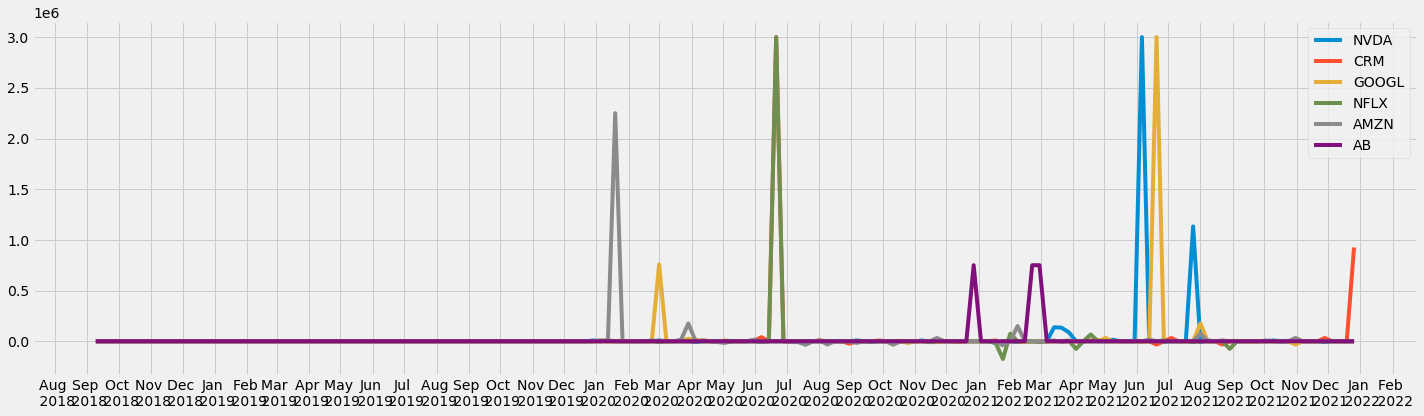

In [15]:
# Import the style from Matplotlib.
from matplotlib import style
# Use the graph style fivethirtyeight.
style.use('fivethirtyeight')

import matplotlib.dates as mdates
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
x_fmt = mdates.DateFormatter('%b \n %Y')

top_stocks_chart, ax = plt.subplots(figsize = (20,6))
ax.plot(temp_resample[top_stocks])
ax.legend(top_stocks)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(x_fmt)

plt.tight_layout()

In [16]:
top_traders = transaction_data_df.groupby('representative')['estimates'].sum().sort_values(ascending = False).head(6).index
print(top_traders)
trades_count_by_rep = transaction_data_df.groupby('representative')['estimates'].count().sort_values(ascending = False)
trades_count_by_rep
frequent_traders = trades_count_by_rep.head(6).index
print(trades_count_by_rep)
print(frequent_traders)

Index(['Hon. Nancy Pelosi', 'Hon. Greg Gianforte', 'Hon. Josh Gottheimer',
       'Hon. Ann Wagner', 'None Kathy Manning', 'Hon. Virginia Foxx'],
      dtype='object', name='representative')
representative
Hon. Josh Gottheimer       844
Hon. Susie Lee             615
Hon. Alan S. Lowenthal     577
Hon. Donna Shalala         559
Hon. Greg Gianforte        497
                          ... 
Hon. Grace Meng              1
Hon. Robert E. Latta         1
Hon. Jamie Raskin            1
Hon. Thomas Massie           1
Hon. Michael K. Simpson      1
Name: estimates, Length: 126, dtype: int64
Index(['Hon. Josh Gottheimer', 'Hon. Susie Lee', 'Hon. Alan S. Lowenthal',
       'Hon. Donna Shalala', 'Hon. Greg Gianforte',
       'Hon. Donald Sternoff Beyer'],
      dtype='object', name='representative')


In [17]:
top_traders_data = {}
top_stocks = {}
bot_stocks = {}
for rep in top_traders:
    top_traders_data[rep] = transaction_data_df.loc[(transaction_data_df['representative'] == rep)]
    
    top_stocks[rep] = top_traders_data[rep].groupby(['ticker'])[['estimates']].sum().sort_values('estimates', ascending = False).head().index
    bot_stocks[rep] = top_traders_data[rep].groupby(['ticker'])[['estimates']].sum().sort_values('estimates', ascending = False).tail().index
    print(top_stocks[rep])
    
    temp = top_traders_data[rep].groupby(['ticker','transaction_date'])[['estimates']].sum()
    top_traders_data[rep] = temp.reset_index().pivot(index = 'transaction_date', columns = 'ticker', values = 'estimates')

Index(['MSFT', 'NVDA', 'CRM', 'GOOGL', 'NFLX'], dtype='object', name='ticker')
Index(['GSAH', 'MSM', 'KMPR', 'STAY', 'NVEE'], dtype='object', name='ticker')
Index(['MSFT', '--', 'UAL', 'AZO', 'NTDOY'], dtype='object', name='ticker')
Index(['--'], dtype='object', name='ticker')
Index(['--', 'APD', 'CB', 'CNC', 'PKG'], dtype='object', name='ticker')
Index(['NHI', 'MO', 'T', 'PAA', 'OLP'], dtype='object', name='ticker')


In [18]:
frequent_traders_data = {}
top_freq_stocks = {}
bot_freq_stocks = {}
for rep in frequent_traders:
    frequent_traders_data[rep] = transaction_data_df.loc[(transaction_data_df['representative'] == rep)]
    
    top_freq_stocks[rep] = frequent_traders_data[rep].groupby(['ticker'])[['estimates']].sum().sort_values('estimates', ascending = False).head().index
    bot_freq_stocks[rep] = frequent_traders_data[rep].groupby(['ticker'])[['estimates']].sum().sort_values('estimates', ascending = False).tail().index
    
    temp = frequent_traders_data[rep].groupby(['ticker', 'transaction_date'])[['estimates']].sum()
    frequent_traders_data[rep] = temp.reset_index().pivot(index = 'transaction_date', columns = 'ticker', values = 'estimates')

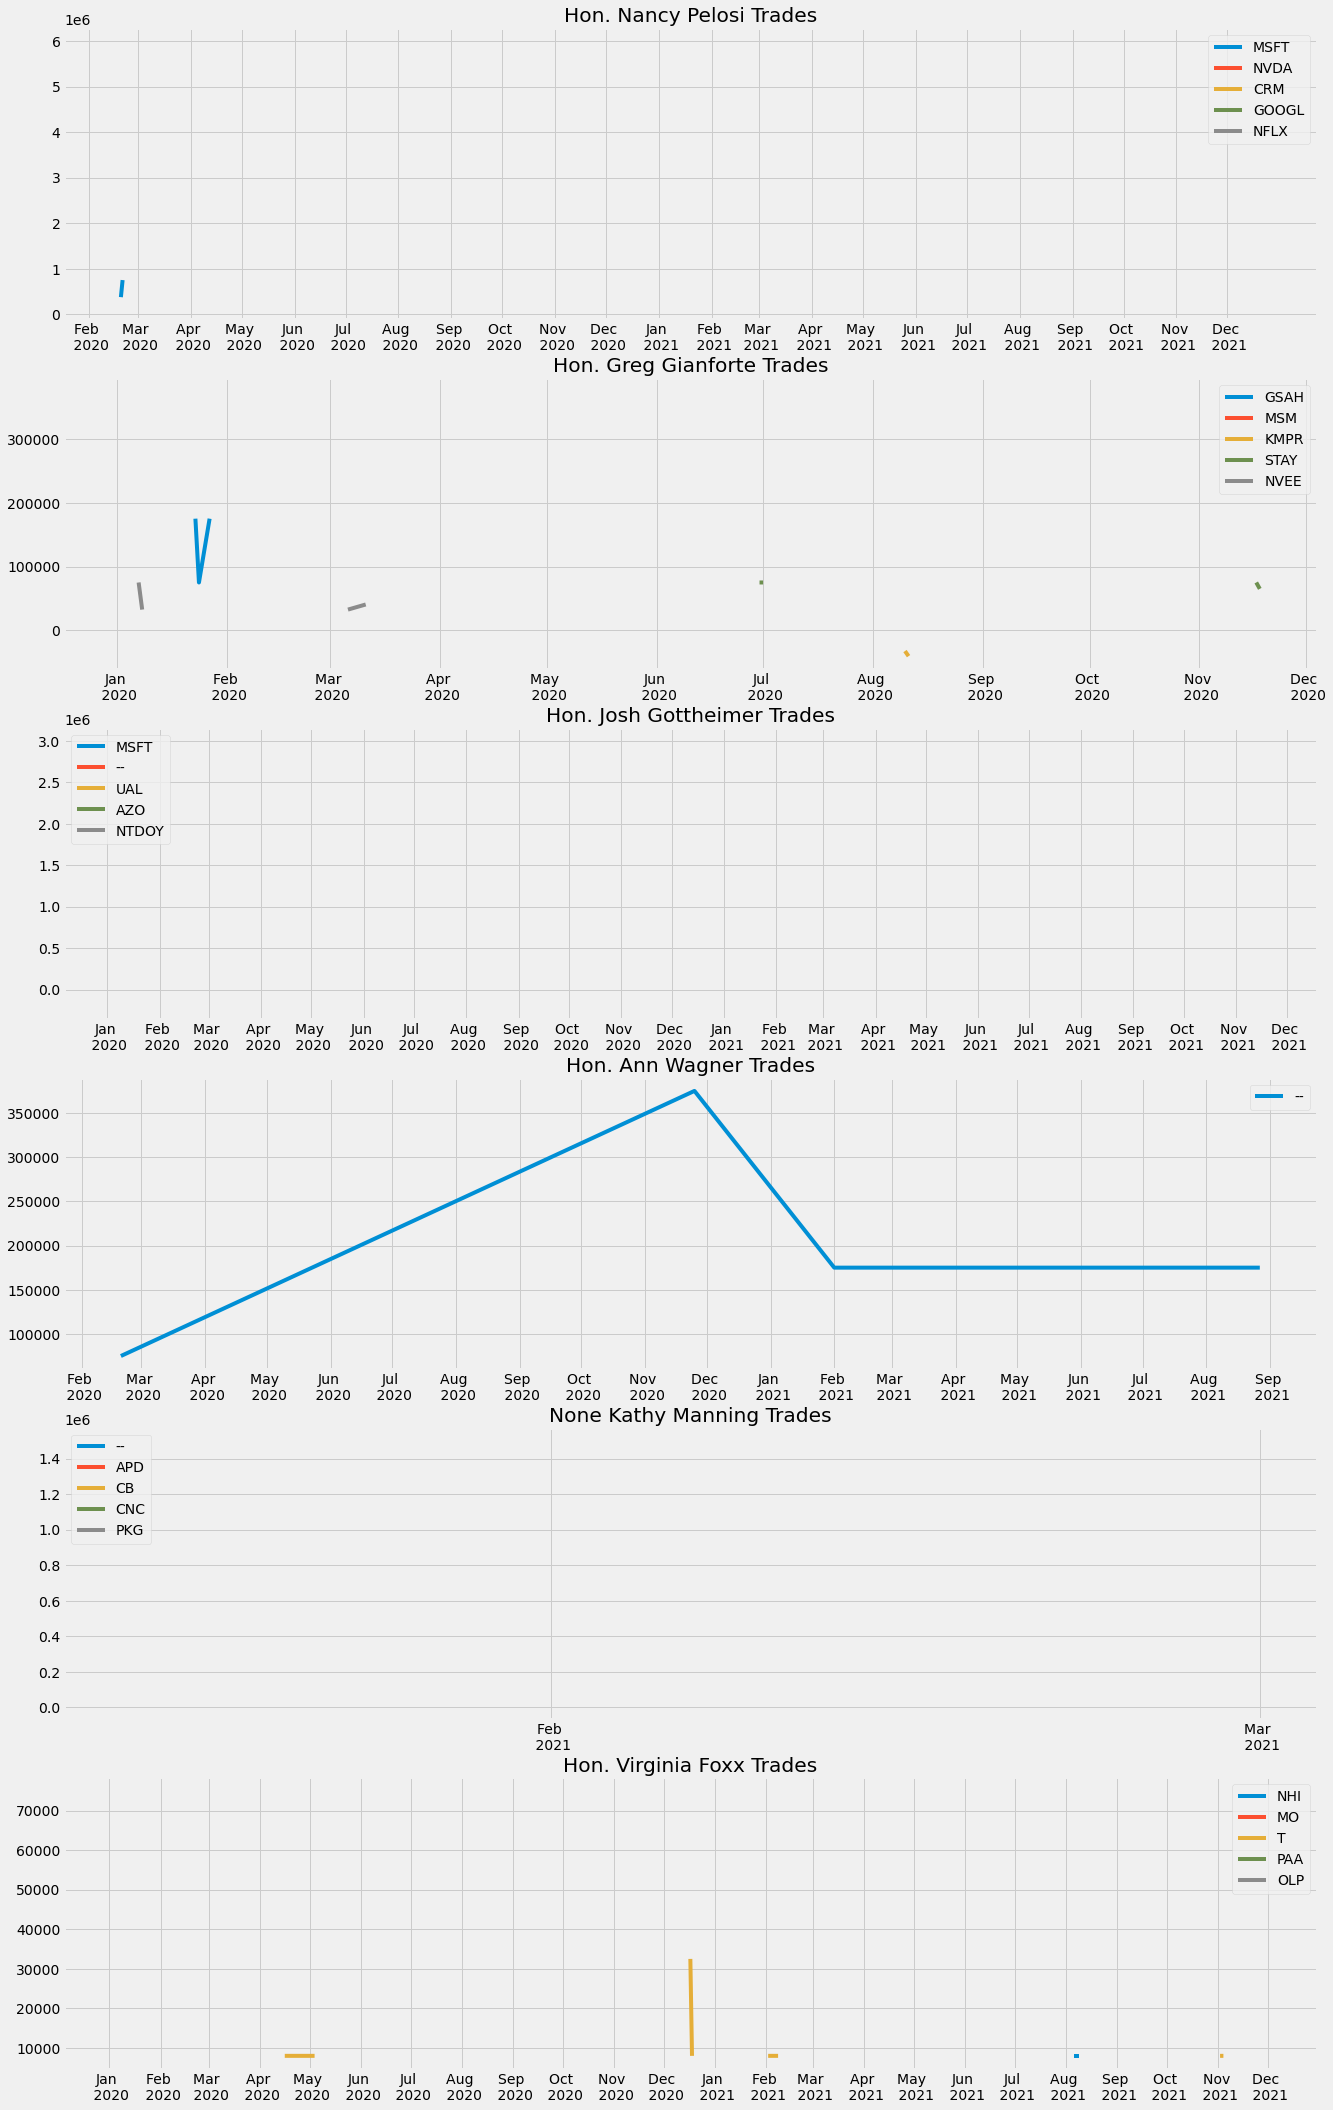

In [19]:
top_traders_by_ticker_chart, ax = plt.subplots(len(top_traders),figsize = (20,35))

for i in range(len(top_traders)):
    # print(top_traders_data[top_traders[i]][top_stocks[top_traders[i]]])
    ax[i].plot(top_traders_data[top_traders[i]][top_stocks[top_traders[i]]])
    ax[i].legend(top_stocks[top_traders[i]])
    ax[i].xaxis.set_major_locator(locator)
    ax[i].xaxis.set_major_formatter(x_fmt)
    ax[i].set_title(f"{top_traders[i]} Trades")

representative    Hon. Abigail Spanberger  Hon. Adam B. Schiff  \
transaction_date                                                 
2018-09-08                            NaN                  NaN   
2018-09-09                            NaN                  NaN   
2018-12-27                            NaN                  NaN   
2019-01-09                            NaN                  NaN   
2019-01-11                            NaN                  NaN   
...                                   ...                  ...   
2021-12-17                            NaN                  NaN   
2021-12-20                            NaN                  NaN   
2021-12-21                            NaN                  NaN   
2021-12-22                            NaN                  NaN   
2021-12-23                            NaN                  NaN   

representative    Hon. Adam Kinzinger  Hon. Alan S. Lowenthal  \
transaction_date                                                
2018-09-08 

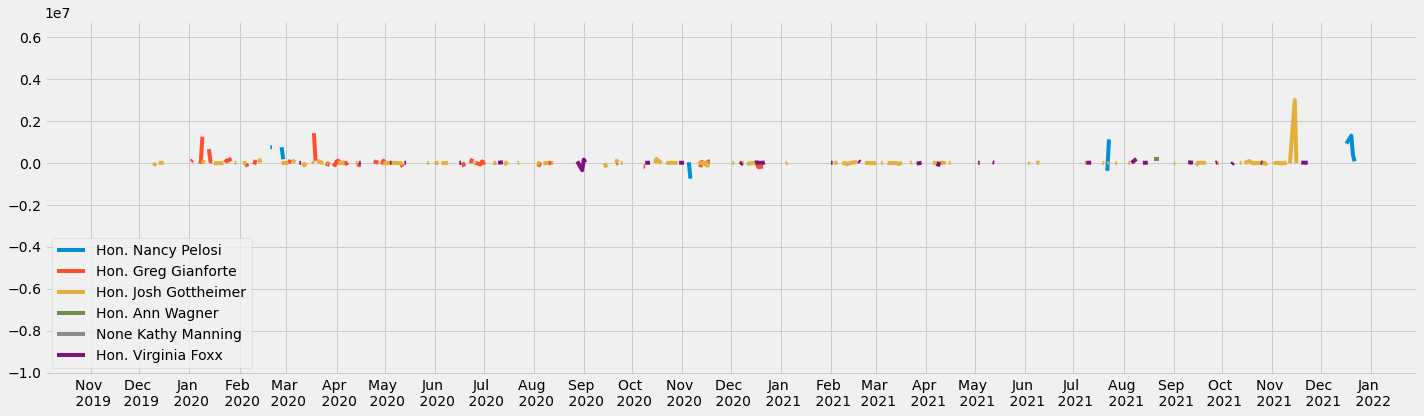

In [23]:
temp = transaction_data_df.groupby(['representative', 'transaction_date'])['estimates'].sum()
temp = temp.reset_index().pivot(index = 'transaction_date', columns = 'representative', values = 'estimates')
print(temp)
#temp = temp.reset_index().pivot(index = 'transaction_date', columns = 'ticker', values = 'estimates')

top_stocks_chart, ax = plt.subplots(figsize = (20,6))
ax.plot(temp[top_traders])
ax.legend(top_traders)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(x_fmt)

plt.tight_layout()

representative    Hon. Abigail Spanberger  Hon. Adam B. Schiff  \
transaction_date                                                 
2018-09-08                            NaN                  NaN   
2018-09-09                            NaN                  NaN   
2018-12-27                            NaN                  NaN   
2019-01-09                            NaN                  NaN   
2019-01-11                            NaN                  NaN   
...                                   ...                  ...   
2021-12-17                            NaN                  NaN   
2021-12-20                            NaN                  NaN   
2021-12-21                            NaN                  NaN   
2021-12-22                            NaN                  NaN   
2021-12-23                            NaN                  NaN   

representative    Hon. Adam Kinzinger  Hon. Alan S. Lowenthal  \
transaction_date                                                
2018-09-08 

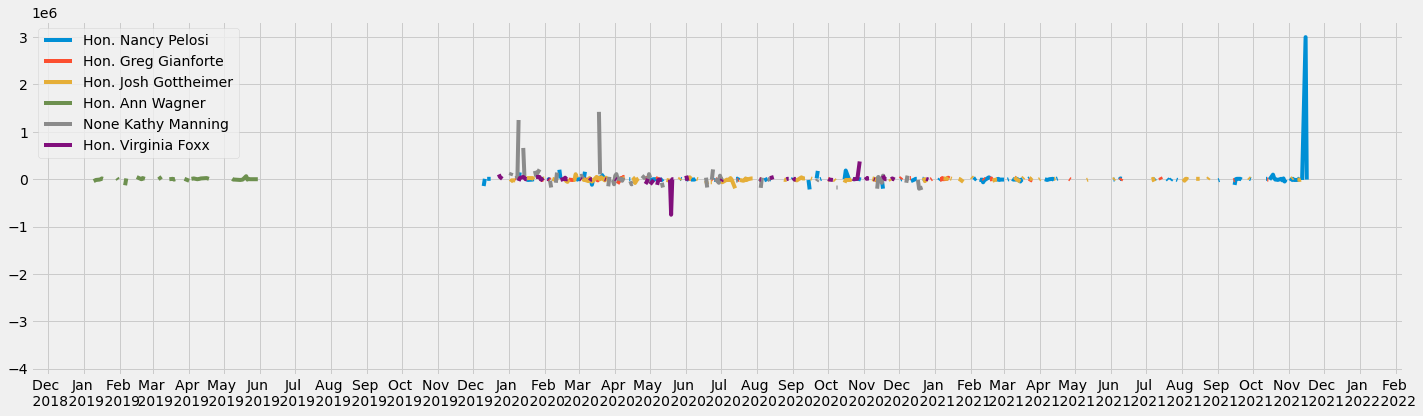

In [24]:
temp = transaction_data_df.groupby(['representative', 'transaction_date'])['estimates'].sum()
temp = temp.reset_index().pivot(index = 'transaction_date', columns = 'representative', values = 'estimates')
print(temp)
#temp = temp.reset_index().pivot(index = 'transaction_date', columns = 'ticker', values = 'estimates')

top_stocks_chart, ax = plt.subplots(figsize = (20,6))
ax.plot(temp[frequent_traders])
ax.legend(top_traders)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(x_fmt)

plt.tight_layout()